In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer

import sklearn

### Class imbalance
from imblearn.over_sampling import RandomOverSampler
import pickle

In [2]:
xgb.__version__

'1.6.1'

In [3]:
plt.style.use('seaborn-dark-palette')

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> Loading Data </div>

In [4]:
data = pd.read_csv('../data/bank-full.csv', sep=';')

In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


###### Overall data summaries

In [6]:
data.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [7]:
data.shape

(45211, 17)

In [8]:
dtypeData = pd.DataFrame({'Variable': data.dtypes.index, 'DataType': data.dtypes})
dtypeData

,Variable,DataType
age,age,int64
job,job,object
marital,marital,object
education,education,object
default,default,object
balance,balance,int64
housing,housing,object
loan,loan,object
contact,contact,object
day,day,int64


In [9]:
numericFields = dtypeData[dtypeData['DataType'] == 'int64']['Variable']
categoricalFields = dtypeData[dtypeData['DataType'] == 'object']['Variable']

<div style='padding: 5px; background-color: rgb(0, 128, 128)'> Univariate Distribution Analysis - <b> Independent Variable </b></div>

###### Numerical Variables

********************age********************


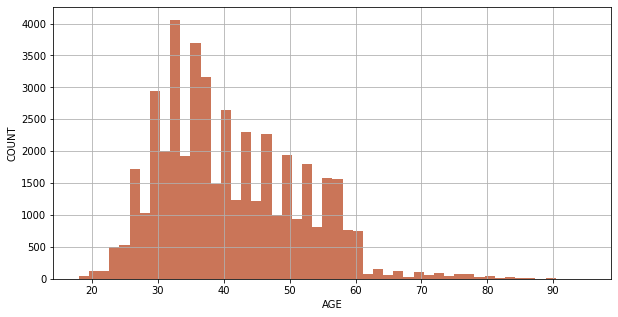

********************balance********************


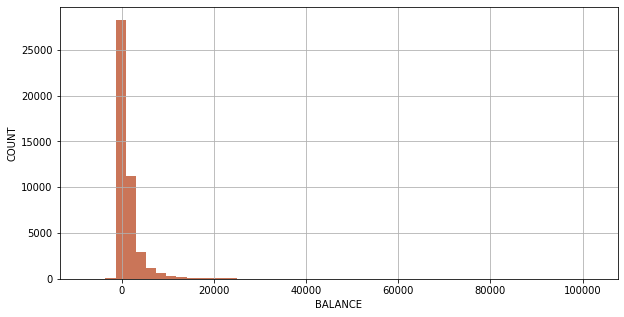

********************day********************


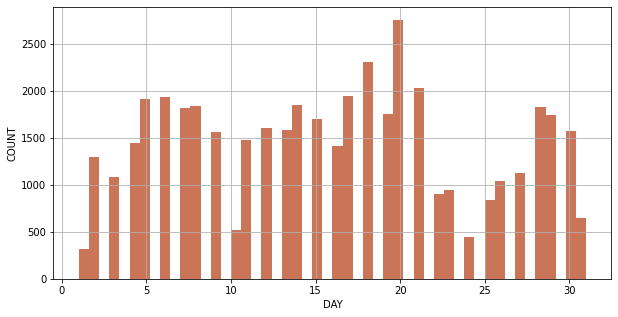

********************duration********************


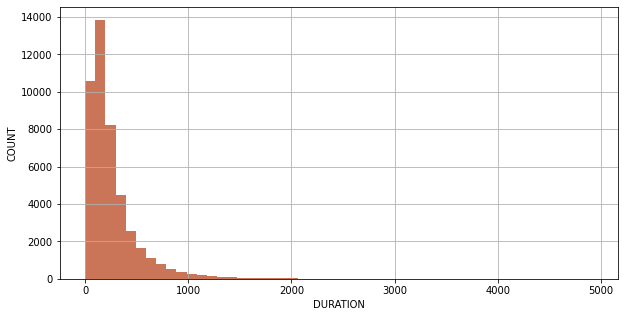

********************campaign********************


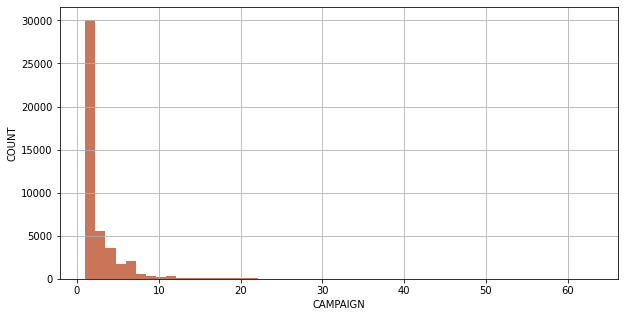

********************pdays********************


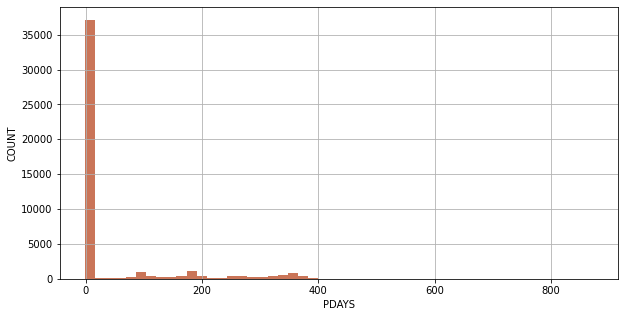

********************previous********************


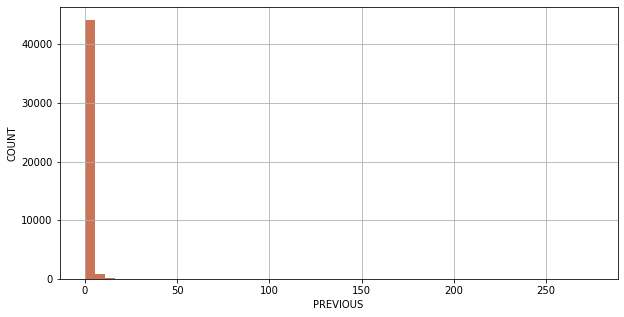

In [9]:
for i in numericFields:
    print("*"*20 + i + "*"*20)
    data[i].hist(bins=50, figsize=(10, 5), color ='#ca7558')
    plt.xlabel(i.upper())
    plt.ylabel('COUNT')
    plt.show()

###### Categorical Variables

********************job********************


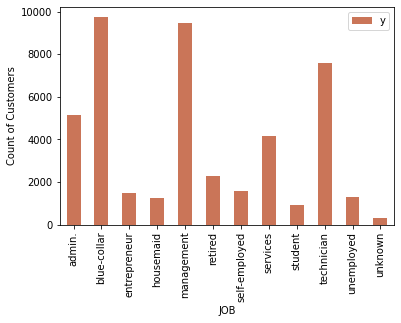

********************marital********************


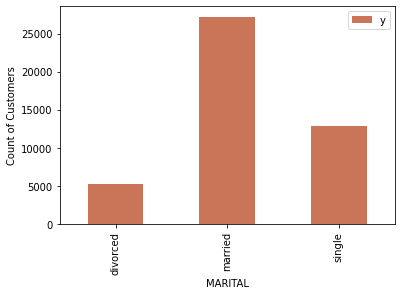

********************education********************


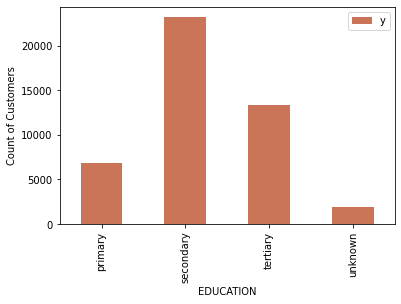

********************default********************


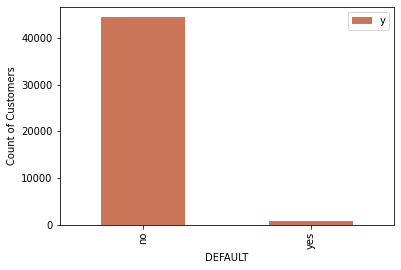

********************housing********************


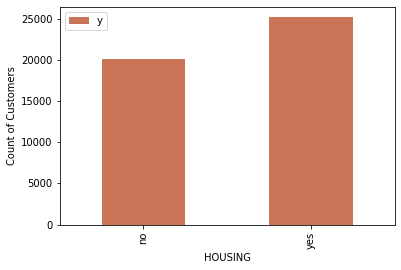

********************loan********************


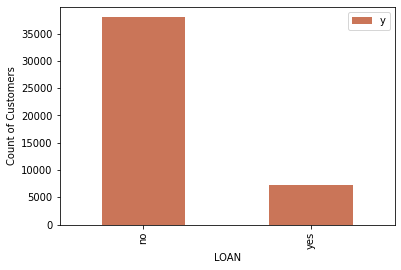

********************contact********************


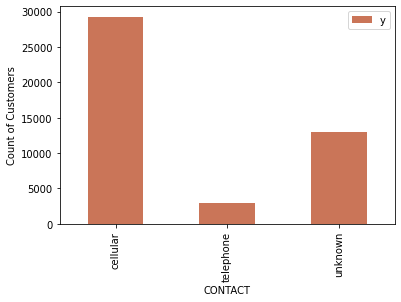

********************month********************


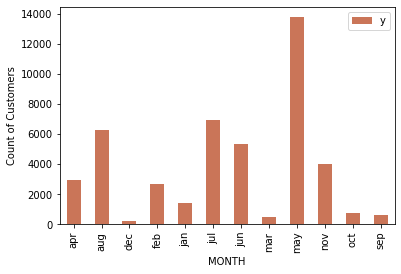

********************poutcome********************


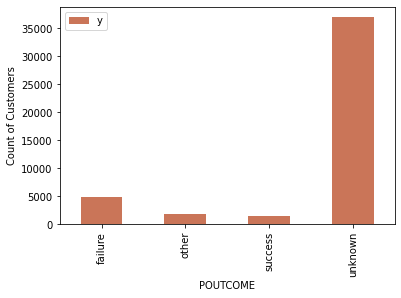

********************y********************


KeyError: 'y'

In [10]:
for i in categoricalFields:
    print("*"*20 + i + "*"*20)
    helperdf = data.groupby([i], as_index = False).count()
    helperdf.plot(x=i, y='y', kind = 'bar', color ='#ca7558')
    plt.xlabel(i.upper())
    plt.ylabel('Count of Customers')
    plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128)'> Univariate Distribution Analysis - <b> Dependent Variable </b></div>

In [ ]:
helperdf = data.groupby(['y'], as_index = False).count()[['y', 'education']]
helperdf.columns = ['y', 'record_count']
helperdf['Prec'] = helperdf['record_count']/helperdf['record_count'].sum()
helperdf.plot(x='y', y='record_count', kind = 'bar', color ='#ca7558')
plt.show()

In [ ]:
helperdf

<div style='padding: 5px; background-color: rgb(0, 128, 128)'> Correlations vs VIF </div>

###### Correlation

In [ ]:
X = pd.get_dummies(data, drop_first=True)
sns.heatmap(X.corr())
X.corr().to_excel('../outputs/correlations_12022023.xlsx')

###### VIF

In [ ]:
vifDf = pd.DataFrame()
X = data[list(set(data.columns)-set(['y']))]
X = pd.get_dummies(X, drop_first=True)
vifDf['Column'] = X.columns
vifDf['vif'] = [variance_inflation_factor(X, i) for i in range(0, len(X.columns))]

In [ ]:
vifDf[vifDf['vif'] >= 3].sort_values(['vif'], ascending = False).to_csv('corr.csv')

<div style='padding: 5px; background-color: rgb(0, 128, 128)'> Bi-variate Analysis </div>

- Understanding the relationship of number (w.r.t averages) and non-numerical (w.r.t frequency) variables with target variable

###### Numerical Fields

In [ ]:
for i in numericFields:
    print('*'*20 + i + '*'*20)
    data.groupby(['y'], as_index=False).mean()[[i, 'y']].plot(x='y', y=i, kind = 'bar', color ='#ca7558')
    plt.xlabel('y')
    plt.ylabel('Percentage of Positive Classes (y=1)')
    plt.show()

###### Non-numerical Fields

In [ ]:
for i in categoricalFields:
    print('*'*20 + i + '*'*20)
    data['y_flag'] = [1 if i == 'yes' else 0 for i in data['y']]
    data.groupby([i], as_index=False).mean()[[i, 'y_flag']].plot(x=i, y='y_flag', kind = 'bar', color ='#ca7558')
    plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128)'> Missing Values </div>

In [ ]:
missingDf = pd.DataFrame({'Variable': data.isna().sum().index, 'Value': data.isna().sum(), 'Precentage': data.isna().sum()/data.shape[0]})
missingDf

###### Target Variable class imbalance

In [ ]:
data.groupby(['y'], as_index = False).count()[['y', 'job']].plot(kind = 'pie', y = 'job', autopct = "%.2f%%", colors = ['#ca7558', '#008080'] )
plt.ylabel('y')
plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> <h3> Data Preparation </h3> </div>

###### Outlier Treatment

In [10]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [11]:
data['age_updated'] = [i if i <= 60 else 60 for i in data['age']]
data['duration_updated'] = [i if i <= 2000 else 2000 for i in data['duration']]
data['balance_updated'] = [i if i <= 40000 else 40000 for i in data['balance']]
data['campaign_updated'] = [i if i <= 30 else 30 for i in data['campaign']]

In [12]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,duration,campaign,pdays,previous,poutcome,y,age_updated,duration_updated,balance_updated,campaign_updated
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,...,261,1,-1,0,unknown,no,58,261,2143,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,...,151,1,-1,0,unknown,no,44,151,29,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,...,76,1,-1,0,unknown,no,33,76,2,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,...,92,1,-1,0,unknown,no,47,92,1506,1
4,33,unknown,single,unknown,no,1,no,no,unknown,5,...,198,1,-1,0,unknown,no,33,198,1,1


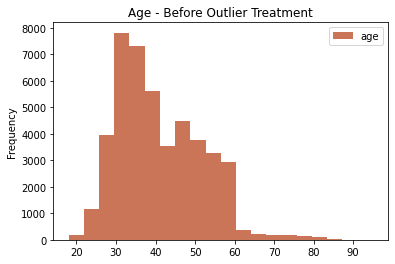

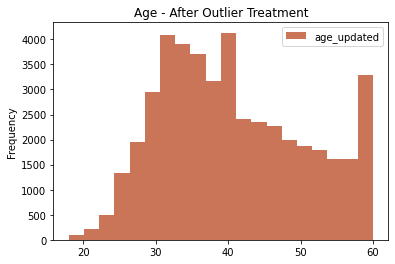

In [13]:
data[['age']].plot.hist(bins = 20, color ='#ca7558', title = 'Age - Before Outlier Treatment')
data[['age_updated']].plot.hist(bins = 20, color ='#ca7558', title = 'Age - After Outlier Treatment')
plt.show()

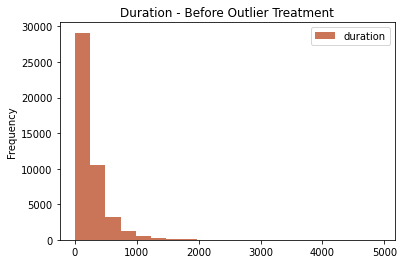

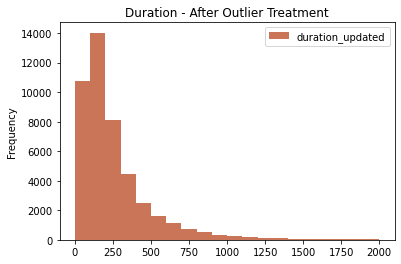

In [14]:
data[['duration']].plot.hist(bins = 20, color ='#ca7558', title = 'Duration - Before Outlier Treatment')
data[['duration_updated']].plot.hist(bins = 20, color ='#ca7558', title = 'Duration - After Outlier Treatment')
plt.show()

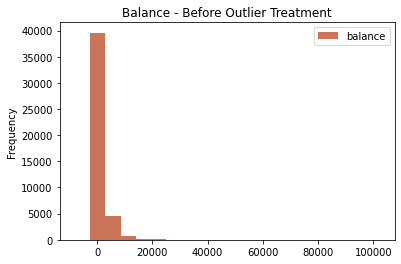

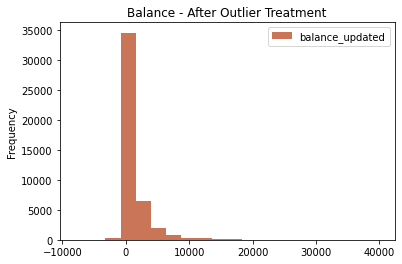

In [13]:
data[['balance']].plot.hist(bins = 20, color ='#ca7558', title = 'Balance - Before Outlier Treatment')
data[['balance_updated']].plot.hist(bins = 20, color ='#ca7558', title = 'Balance - After Outlier Treatment')
plt.show()

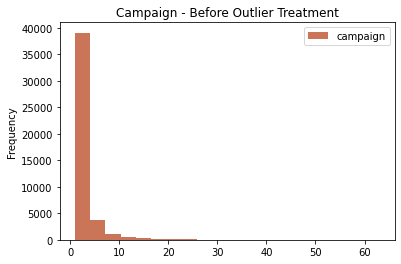

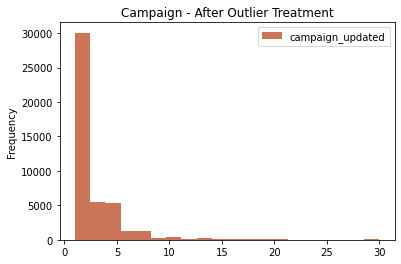

In [14]:
data[['campaign']].plot.hist(bins = 20, color ='#ca7558', title = 'Campaign - Before Outlier Treatment')
data[['campaign_updated']].plot.hist(bins = 20, color ='#ca7558', title = 'Campaign - After Outlier Treatment')
plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> <h3> Feature Engineering </h3> </div>

###### Eliminating correlated variables

In [15]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_updated', 'duration_updated',
       'balance_updated', 'campaign_updated'],
      dtype='object')

In [15]:
data = data.drop(['pdays'], axis = 1)

###### Dummy coding categorical variables

In [16]:
data = pd.get_dummies(data)

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> <h3> Model Development - Decision Tree </h3> </div>

###### Test vs Train split

In [17]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data[['age_updated', 'duration_updated', 'balance_updated',
       'campaign_updated', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_yes', 
       'housing_yes', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_success']], data['y_yes'], test_size=0.2, random_state=2, stratify=data['y_yes'])

###### Class blancing for addressing class imbalancing using oversampling

In [18]:
overSampleData = RandomOverSampler(sampling_strategy=0.5, random_state=42)
XtrainOver, ytrainOver = overSampleData.fit_resample(Xtrain, ytrain)

In [19]:
XtrainOver.shape

(47905, 44)

In [20]:
Xtrain.shape

(36168, 44)

###### Model Building

In [25]:
modelF1Score = make_scorer(f1_score)

In [26]:
gridParam = {'max_depth': list(range(1, 20, 1)), 'max_features': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
grid = GridSearchCV(DecisionTreeClassifier(random_state = 2), gridParam, scoring = modelF1Score)
grid.fit(XtrainOver, ytrainOver)


print('Train Evaluation')
print(classification_report(ytrainOver, grid.predict(XtrainOver), target_names=['no', 'yes']))

print('*'*10)
print('Test Evaluation')
print(classification_report(ytest, grid.predict(Xtest), target_names=['no', 'yes']))

Train Evaluation
              precision    recall  f1-score   support

          no       0.98      0.97      0.98     31937
         yes       0.94      0.97      0.95     15968

    accuracy                           0.97     47905
   macro avg       0.96      0.97      0.96     47905
weighted avg       0.97      0.97      0.97     47905

**********
Test Evaluation
              precision    recall  f1-score   support

          no       0.94      0.91      0.92      7985
         yes       0.45      0.53      0.48      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.72      0.70      9043
weighted avg       0.88      0.87      0.87      9043



In [27]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=19, max_features=19, random_state=2)

In [28]:
a = pd.DataFrame(grid.cv_results_)
a['max_depth'] = [i['max_depth'] for i in a['params']]
a['max_features'] = [i['max_features'] for i in a['params']]

- Saving model

In [29]:
dtModel = grid.best_estimator_

In [30]:
#pickle.dump(dtModel, open('../models/decision_tree_24032023.sav', 'wb'))

F:\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


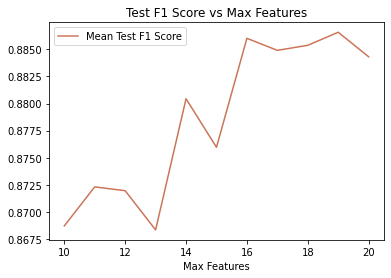

In [31]:
pd.DataFrame({'Mean Test F1 Score': a[a['max_depth'] == 19]['mean_test_score'], 'Max Features': a[a['max_depth'] == 19]['param_max_features']}).plot(x = 'Max Features', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Features', color ='#ca7558')
plt.show()

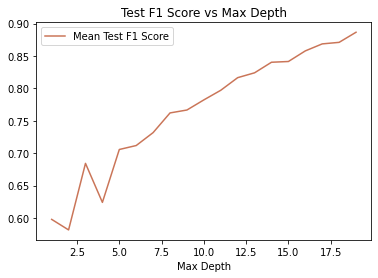

In [32]:
pd.DataFrame({'Mean Test F1 Score': a[a['max_features'] == 19]['mean_test_score'], 'Max Depth': a[a['max_features'] == 19]['param_max_depth']}).plot(x = 'Max Depth', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Depth', color ='#ca7558')
plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> <h3> Model Development - Random Forest </h3> </div>

In [47]:
# gridParam = {'n_estimators' : range(1, 200, 10) , 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
# grid = GridSearchCV(RandomForestClassifier(random_state = 2), gridParam, scoring = modelF1Score, cv = 2)
# grid.fit(XtrainOver, ytrainOver)

gridParam = {'n_estimators' : [101] , 'max_depth': [15]}
grid = GridSearchCV(RandomForestClassifier(random_state = 2), gridParam, scoring = modelF1Score, cv = 2)
grid.fit(XtrainOver, ytrainOver)


print('Train Evaluation')
print(classification_report(ytrain, grid.predict(Xtrain), target_names=['no', 'yes']))

print('*'*10)
print('Test Evaluation')
print(classification_report(ytest, grid.predict(Xtest), target_names=['no', 'yes']))

Train Evaluation
              precision    recall  f1-score   support

          no       0.99      0.95      0.97     31937
         yes       0.72      0.89      0.80      4231

    accuracy                           0.95     36168
   macro avg       0.85      0.92      0.88     36168
weighted avg       0.95      0.95      0.95     36168

**********
Test Evaluation
              precision    recall  f1-score   support

          no       0.95      0.93      0.94      7985
         yes       0.54      0.67      0.60      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.80      0.77      9043
weighted avg       0.91      0.90      0.90      9043



In [48]:
grid.best_estimator_

RandomForestClassifier(max_depth=15, n_estimators=101, random_state=2)

- Saving best model

In [49]:
rfModel = grid.best_estimator_

In [50]:
#pickle.dump(rfModel, open('../models/random_forest_24032023.sav', 'wb'))

- Analyzing results

In [155]:
a = pd.DataFrame(grid.cv_results_)
a['max_depth'] = [i['max_depth'] for i in a['params']]
a['n_estimators'] = [i['n_estimators'] for i in a['params']]

F:\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


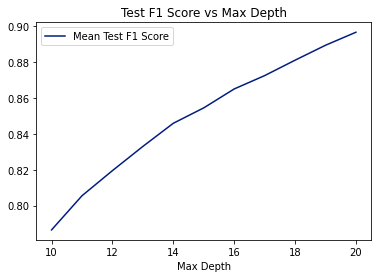

In [156]:
pd.DataFrame({'Mean Test F1 Score': a[a['n_estimators'] == 101]['mean_test_score'], 'Max Depth': a[a['n_estimators'] == 101]['param_max_depth']}).plot(x = 'Max Depth', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Depth')
plt.show()

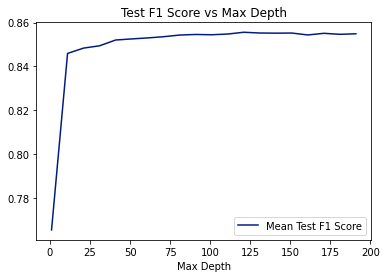

In [157]:
pd.DataFrame({'Mean Test F1 Score': a[a['max_depth'] == 15]['mean_test_score'], 'Max Depth': a[a['max_depth'] == 15]['param_n_estimators']}).plot(x = 'Max Depth', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Depth')
plt.show()

<div style='padding: 5px; background-color: rgb(0, 128, 128); color: white'> <h3> Model Development - Xgboost </h3> </div>

In [52]:
xgbtModel = xgb.XGBClassifier()

In [55]:
# gridParam = {'n_estimators' : list(range(50, 150, 20)) , 'max_depth': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}
# grid = GridSearchCV(xgbtModel, gridParam, verbose=10, scoring = modelF1Score, cv = 2)
# grid.fit(XtrainOver, ytrainOver)

gridParam = {'n_estimators' : [90] , 'max_depth': [7]}
grid = GridSearchCV(xgbtModel, gridParam, verbose=10, scoring = modelF1Score, cv = 2)
grid.fit(XtrainOver, ytrainOver)


print('Train Evaluation')
print(classification_report(ytrain, grid.predict(Xtrain), target_names=['no', 'yes']))

print('*'*10)
print('Test Evaluation')
print(classification_report(ytest, grid.predict(Xtest), target_names=['no', 'yes']))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START max_depth=7, n_estimators=90................................
[CV 1/2; 1/1] END .max_depth=7, n_estimators=90;, score=0.857 total time=   2.4s
[CV 2/2; 1/1] START max_depth=7, n_estimators=90................................
[CV 2/2; 1/1] END .max_depth=7, n_estimators=90;, score=0.866 total time=   2.4s
Train Evaluation
              precision    recall  f1-score   support

          no       0.99      0.95      0.97     31937
         yes       0.72      0.93      0.81      4231

    accuracy                           0.95     36168
   macro avg       0.85      0.94      0.89     36168
weighted avg       0.96      0.95      0.95     36168

**********
Test Evaluation
              precision    recall  f1-score   support

          no       0.95      0.92      0.94      7985
         yes       0.52      0.66      0.58      1058

    accuracy                           0.89      9043
   macro avg       0.73     

In [56]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=90, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [57]:
xgbModel = grid.best_estimator_

In [58]:
#pickle.dump(xgbModel, open('../models/xgboost_model_24032023.sav', 'wb'))

In [163]:
a = pd.DataFrame(grid.cv_results_)
a['max_depth'] = [i['max_depth'] for i in a['params']]
a['n_estimators'] = [i['n_estimators'] for i in a['params']]

F:\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


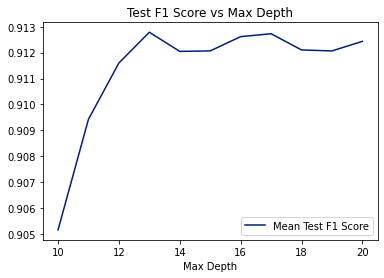

In [164]:
pd.DataFrame({'Mean Test F1 Score': a[a['n_estimators'] == 130]['mean_test_score'], 'Max Depth': a[a['n_estimators'] == 130]['param_max_depth']}).plot(x = 'Max Depth', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Depth')
plt.show()

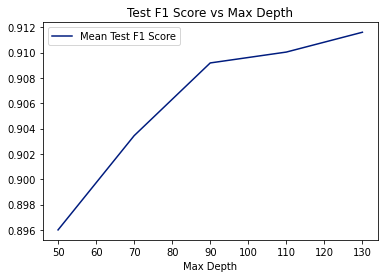

In [165]:
pd.DataFrame({'Mean Test F1 Score': a[a['max_depth'] == 12]['mean_test_score'], 'Max Depth': a[a['max_depth'] == 12]['param_n_estimators']}).plot(x = 'Max Depth', y = 'Mean Test F1 Score', title = 'Test F1 Score vs Max Depth')
plt.show()

###### Model Ensemble

In [42]:
dfModel = pickle.load(open('../models/decision_tree_24032023.sav', 'rb'))
rfModel = pickle.load(open('../models/random_forest_24032023.sav', 'rb'))
xgbModel = pickle.load(open('../models/xgboost_model_24032023.sav', 'rb'))

In [43]:
def ensembleResults(res1, res2, res3):
    total = np.add(res2, res3)
    total = [0 if (i==0) & (j==0) else 1 for i,j in zip(res2, res3)]
    
    #total = np.round(total, 0)
    
    return total

- Train Ensemble

In [46]:
list(rfModel.predict(Xtrain))

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,


In [24]:
print('Train Evaluation')
print(classification_report(ytrain, ensembleResults(dfModel.predict(Xtrain), rfModel.predict(Xtrain), xgbModel.predict(Xtrain)), target_names=['no', 'yes']))

Train Evaluation
              precision    recall  f1-score   support

          no       1.00      0.95      0.97     31937
         yes       0.72      0.98      0.83      4231

    accuracy                           0.95     36168
   macro avg       0.86      0.96      0.90     36168
weighted avg       0.96      0.95      0.96     36168



- Test Ensemble

In [25]:
print(classification_report(ytest, ensembleResults(dfModel.predict(Xtest), rfModel.predict(Xtest), xgbModel.predict(Xtest)), target_names=['no', 'yes']))

              precision    recall  f1-score   support

          no       0.96      0.91      0.93      7985
         yes       0.51      0.70      0.59      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.81      0.76      9043
weighted avg       0.91      0.89      0.89      9043



### Prediction pipeline for webapp

In [70]:
Xtrain

,age_updated,duration_updated,balance_updated,campaign_updated,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success
20300,34,383,421,3,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
37983,36,480,1041,2,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
29466,30,165,363,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43517,31,654,26965,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9388,56,67,2152,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19797,33,106,2071,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
37672,44,7,275,5,4,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4869,31,192,1914,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12426,33,266,740,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [27]:
dfModel = pickle.load(open('../models/decision_tree_24032023.sav', 'rb'))
rfModel = pickle.load(open('../models/random_forest_24032023.sav', 'rb'))
xgbModel = pickle.load(open('../models/xgboost_model_24032023.sav', 'rb'))

In [21]:
model = pickle.load(open('../models/xgboost_model_24032023.sav', 'rb'))

In [26]:
results = Xtrain.copy()
results['Pred'] = model.predict(Xtrain)

In [27]:
results[results['Pred'] == 1].to_csv('predictoin_Sample.csv')

In [23]:
sum(model.predict(Xtrain))

5458

In [69]:
for i in range(1, 100):
    ## Loading saved model
    try:
        
        dataCopy = pd.DataFrame(Xtrain.loc[[i]])
        dataCopy = pd.get_dummies(dataCopy)


        ## Data prep for model prediction
        missingFeatures = list(set(list(model.feature_names_in_)) - set(list(pd.get_dummies(dataCopy).columns)))

        ## Adding missing fields for prediction
        for i in missingFeatures:
            dataCopy[i] = 0

        print(model.predict_proba(dataCopy[model.feature_names_in_]))
        print(model.predict(dataCopy[model.feature_names_in_]))
    except:
        print("skip")

[[0.996956   0.00304398]]
[0]
[[0.9987536 0.0012464]]
[0]
[[9.9912798e-01 8.7202725e-04]]
[0]
[[0.9811249  0.01887511]]
[0]
[[0.9977893  0.00221067]]
[0]
[[0.9895223  0.01047772]]
[0]
[[0.9947046  0.00529541]]
[0]
[[9.9986464e-01 1.3537807e-04]]
[0]
skip
[[0.9979967 0.0020033]]
[0]
[[0.998286   0.00171397]]
[0]
skip
[[9.9919075e-01 8.0925610e-04]]
[0]
[[0.998421 0.001579]]
[0]
[[0.98962474 0.01037526]]
[0]
[[9.9963087e-01 3.6913628e-04]]
[0]
[[9.9988484e-01 1.1513565e-04]]
[0]
[[9.990173e-01 9.826903e-04]]
[0]
[[9.9989480e-01 1.0518013e-04]]
[0]
[[0.99695253 0.00304747]]
[0]
[[0.99859416 0.00140581]]
[0]
[[0.99855113 0.00144887]]
[0]
[[0.9795321 0.0204679]]
[0]
skip
[[0.9984318  0.00156817]]
[0]
[[0.9925219  0.00747814]]
[0]
[[9.995196e-01 4.804243e-04]]
[0]
skip
[[0.99216443 0.00783554]]
[0]
[[0.9733394  0.02666063]]
[0]
[[0.99334407 0.00665594]]
[0]
[[0.99683845 0.00316154]]
[0]
[[0.9966118  0.00338824]]
[0]
[[0.98086447 0.01913554]]
[0]
[[0.9963357  0.00366434]]
[0]
skip
[[0.4733829

In [68]:
for i in range(1, 100):
    ## Loading saved model
    try:
        
        dataCopy = pd.DataFrame(Xtrain.loc[[i]])
        dataCopy = pd.get_dummies(dataCopy)


        ## Data prep for model prediction
        missingFeatures = list(set(list(model.feature_names_in_)) - set(list(pd.get_dummies(dataCopy).columns)))

        ## Adding missing fields for prediction
        for i in missingFeatures:
            dataCopy[i] = 0

        print(model.predict(dataCopy[model.feature_names_in_]))
    except:
        print("skip")

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
skip
[0]
[0]
skip
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
skip
[0]
[0]
[0]
skip
[0]
[0]
[0]
[0]
[0]
[0]
[0]
skip
[1]
skip
[0]
skip
[0]
[0]
[0]
[0]
[0]
skip
skip
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
skip
[0]
[0]
[0]
skip
[1]
[0]
[0]
[0]
skip
[0]
skip
[0]
skip
[0]
[0]
[0]
[0]
skip
skip
[0]
[0]
[0]
[0]
skip
[0]
[0]
[1]
skip
[0]
[1]
[1]
skip
[0]
[0]
[0]
[0]
[0]
[0]
skip
[0]
[0]
[0]
skip


###### Feature Importance - RF

In [37]:
featureImpDf = pd.DataFrame({'Value': rfModel.feature_importances_, 'Feature': Xtrain.columns})

In [38]:
featureImpDf.sort_values(['Value'], ascending = False)

,Value,Feature
1,0.367675,duration_updated
2,0.080156,balance_updated
0,0.074291,age_updated
43,0.062512,poutcome_success
4,0.044107,previous
3,0.034516,campaign_updated
25,0.032566,housing_yes
29,0.024988,contact_unknown
40,0.017387,month_oct
37,0.016745,month_mar


In [39]:
featureImpDf.to_csv('rf_feaure_imp.csv')

###### Feature Importance - XGboost

In [172]:
featureImpDf = pd.DataFrame({'Value': xgbModel.feature_importances_, 'Feature': Xtrain.columns})
featureImpDf.sort_values(['Value'], ascending = False)

,Value,Feature
43,0.257692,poutcome_success
29,0.130038,contact_unknown
37,0.059936,month_mar
40,0.043858,month_oct
34,0.038831,month_jan
35,0.030280,month_jul
31,0.027501,month_aug
25,0.024401,housing_yes
41,0.022773,month_sep
39,0.022318,month_nov


<div style='padding: 5px; background-color: rgb(0, 0, 0)'> Insights </div>

- No missing values observed in any of the column
- Data has a good mix of categorical and continous variables
- Dataset is slightly imbalanced with 11.7% of positive classes
- poutcome_unknown, month_may, day and marital_married are highly correlated with > 5 VIF
    - poutcome is highly correlated with pdays
    - Education secondary is correlated with education tertiary
    - Married_single is correlated with marital_married